In [10]:
import re
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import joblib

# --- Load your dataset (already done before) ---
file_path = "/Users/giuliogarotti/Documents/GitHub/Projet_chem/uspto50/uspto50/reaction_templates_50k_train.csv"
df = pd.read_csv(file_path, sep="\t")

colonnes_necessaires = ['RxnSmilesClean', 'PseudoHash', 'RetroTemplate', 'TemplateHash']
df = df[colonnes_necessaires]
df_unique = df.drop_duplicates(subset=['PseudoHash'], keep='first')

# --- 1. Remove atom mapping ---

def remove_atom_mapping(smiles):
    """Remove :number mapping from SMILES."""
    return re.sub(r":\d+", "", smiles)

# --- 2. Split SMILES into reactants and products ---

def split_rxn_smiles(rxn_smiles):
    try:
        parts = rxn_smiles.split(">>")
        if len(parts) != 2:
            return [], []
        reactants_raw, products_raw = parts
        reactants = reactants_raw.split(".")
        products = products_raw.split(".")
        return reactants, products
    except Exception as e:
        print(f"Erreur dans split_rxn_smiles: {rxn_smiles} -> {e}")
        return [], []

# --- 3. Convert SMILES to fingerprints (after cleaning) ---

def smiles_to_fingerprints(smiles):
    try:
        reactants_smiles, products_smiles = split_rxn_smiles(smiles)

        def mols_to_fps(smiles_list):
            fps = []
            n_bits = 2048
            for s in smiles_list:
                cleaned_s = remove_atom_mapping(s)
                mol = Chem.MolFromSmiles(cleaned_s)
                if mol is None:
                    print(f"Molécule invalide : {s}")
                    continue  # <-- SKIP invalid molecules
                fp = AllChem.GetMorganFingerprint(mol, radius=3)
                arr = np.zeros((n_bits,), dtype=int)
                if isinstance(fp, Chem.DataStructs.UIntSparseIntVect):
                    on_bits = list(fp.GetNonzeroElements().keys())
                    for bit in on_bits:
                        arr[bit % n_bits] = 1
                fps.append(arr)
            return fps

        reactants_fps = mols_to_fps(reactants_smiles)
        products_fps = mols_to_fps(products_smiles)

        return reactants_fps, products_fps

    except Exception as e:
        print(f"Erreur parsing SMILES: {smiles} -> {e}")
        return [], []

# --- 4. Prepare training data X, y ---

def prepare_fingerprints_for_training(df):
    X = []
    y = []
    for idx, (smiles, target) in enumerate(zip(df['RxnSmilesClean'], df['TemplateHash'])):
        reactants_fps, products_fps = smiles_to_fingerprints(smiles)
        if reactants_fps and products_fps:
            X.extend(reactants_fps)
            y.extend([target] * len(reactants_fps))
            X.extend(products_fps)
            y.extend([target] * len(products_fps))
        else:
            print(f"Skipping reaction at index {idx}: {smiles}")

    X = np.array(X)
    y = np.array(y)

    print(f"Fingerprint preparation finished. Total examples: {X.shape[0]}")
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"Mismatch: X {X.shape[0]} vs y {y.shape[0]}")

    return X, y

print(X.shape, y.shape)

(108074, 2048) (108074,)


[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerator
[13:33:33] DEPRECATION WARNING: please use MorganGenerat

Fingerprint preparation finished. Total examples: 108074
Préparation terminée : X shape = (108074, 2048), y shape = (108074,)


/opt/anaconda3/envs/projet_chem/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training Progress:  55%|█████▌    | 11/20 [26:12<18:42, 124.73s/it] /opt/anaconda3/envs/projet_chem/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
Training Progress: 100%|██████████| 20/20 [42:19<00:00, 126.99s/it]


Training finished!
Model saved as 'mlp_classifier_model.pkl'
Scaler saved as 'scaler.pkl'


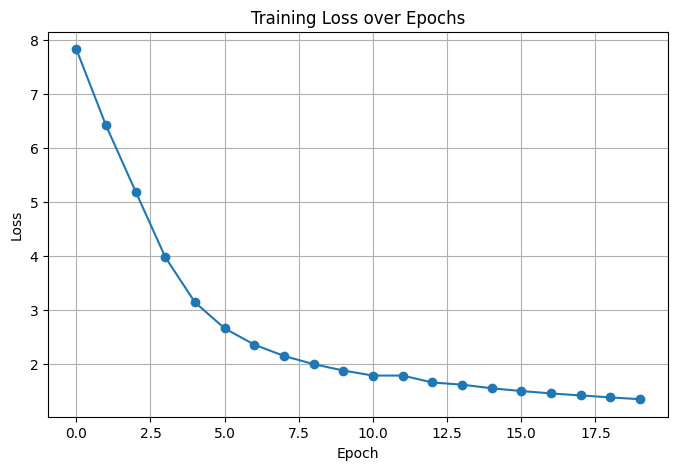

In [12]:
# Générer X et y
X, y = prepare_fingerprints_for_training(df_unique)
print(f"Préparation terminée : X shape = {X.shape}, y shape = {y.shape}")

# --- 3. Entraîner le modèle ---

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import joblib

# Assuming you already have X and y ready
# If not, you should prepare them first like before

# 1. Scale your data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Define the model
model = MLPClassifier(hidden_layer_sizes=(64, 64),
                      max_iter=1,  # Only 1 epoch per call
                      warm_start=True,  # Keep training across multiple partial_fit
                      random_state=42)

# 3. Prepare for training
n_epochs = 20
classes = np.unique(y)  # Needed for partial_fit
losses = []  # To track the loss over epochs

# 4. Training loop with progress bar and loss tracking
for epoch in tqdm(range(n_epochs), desc="Training Progress"):
    model.partial_fit(X_scaled, y, classes=classes)
    losses.append(model.loss_)

print("Training finished!")

# 5. Save the model and scaler
joblib.dump(model, 'mlp_classifier_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Model saved as 'mlp_classifier_model.pkl'")
print("Scaler saved as 'scaler.pkl'")

# 6. Plot the loss curve
plt.figure(figsize=(8, 5))
plt.plot(losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
